# 📌 Лабораторна робота №3
## Нечітка логіка: проєктування інтелектуального модуля.

**Мета** лабораторної роботи полягає в ознайомленні студентів із
принципами нечіткої логіки та її застосуванням для проєктування
інтелектуального модуля, здатного приймати рішення в умовах
невизначеності та неповної інформації. Під час виконання роботи студенти
навчаться формулювати нечіткі множини, визначати функції належності,
створювати правила нечіткого виведення та реалізовувати систему, що імітує
процес прийняття рішень у реальних умовах. Практичний аспект полягає в
розробці модуля, який на основі нечітких вхідних даних генерує обґрунтовані
вихідні результати, що можуть застосовуватися для інтелектуальних систем
керування, рекомендаційних сервісів або пошуку з нечіткою відповідністю.

<br>

**Виконав:** ст. гр. ОІ-31 | _Мацишин Михайло_

**Прийняв:** _Лящинський Петро Борисович_

## 1| Отримання та підготовка датасету

In [28]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz
import jellyfish
import matplotlib.pyplot as plt
from tabulate import tabulate
from Levenshtein import distance as levenshtein_distance

In [65]:
# Завантаження датасету
file_path = 'data/room_type.csv'
df_full = pd.read_csv(file_path)

# Перегляд у форматі таблички
df_full.head(105).style.set_table_styles(
    [{'selector': 'th', 'props': [('font-weight', 'bold')]}]
)

,Expedia,Booking.com
0,"Deluxe Room, 1 King Bed",Deluxe King Room
1,"Standard Room, 1 King Bed, Accessible",Standard King Roll-in Shower Accessible
2,"Grand Corner King Room, 1 King Bed",Grand Corner King Room
3,"Suite, 1 King Bed (Parlor)",King Parlor Suite
4,"High-Floor Premium Room, 1 King Bed",High-Floor Premium King Room
5,"Traditional Double Room, 2 Double Beds",Double Room with Two Double Beds
6,"Room, 1 King Bed, Accessible",King Room - Disability Access
7,"Deluxe Room, 1 King Bed",Deluxe King Room
8,Deluxe Room,Deluxe Room (Non Refundable)
9,"Room, 2 Double Beds (19th to 25th Floors)",Two Double Beds - Location Room (19th to 25th Floors)


In [68]:
# Перейменування колонок
df_full.columns = ['Expedia', 'Booking']

In [69]:
# Перевірка назв колонок
print("\nСписок колонок у датасеті:")
print(list(df_full.columns))


Список колонок у датасеті:
['Expedia', 'Booking']


In [70]:
# Використовуємо повний датасет
df = df_full[['Expedia', 'Booking']].copy()
df['ID'] = range(1, len(df) + 1)  # Додаємо колонку ID
df = df[['ID', 'Expedia', 'Booking']]  # Переставляємо колонку ID на початок

In [78]:
df.head(5).style.set_table_styles(
    [{'selector': 'th', 'props': [('font-weight', 'bold')]}]
)

,ID,Expedia,Booking
0,1,"Deluxe Room, 1 King Bed",Deluxe King Room
1,2,"Standard Room, 1 King Bed, Accessible",Standard King Roll-in Shower Accessible
2,3,"Grand Corner King Room, 1 King Bed",Grand Corner King Room
3,4,"Suite, 1 King Bed (Parlor)",King Parlor Suite
4,5,"High-Floor Premium Room, 1 King Bed",High-Floor Premium King Room


In [79]:
print(f"\nКількість записів: {len(df)}")


Кількість записів: 103


## 2| Визначення вхідних параметрів

Додаємо класифікацію довжини термінів для всіх записів.

**Довжина термінів:** Обчислюємо кількість слів у кожному записі для колонок Expedia і Booking.

**Класифікація:** Застосовуємо правила (≤3 — короткий, 4-5 — середній, >5 — довгий) до всіх 103 записів.

In [85]:
# Додаємо довжину термінів (кількість слів)
df['expedia_length'] = df['Expedia'].apply(lambda x: len(str(x).split()))
df['booking_length'] = df['Booking'].apply(lambda x: len(str(x).split()))

# Класифікація довжини
def classify_length(length):
    if length <= 3:
        return 'короткий'
    elif length <= 5:
        return 'середній'
    else:
        return 'довгий'

df['expedia_length_class'] = df['expedia_length'].apply(classify_length)
df['booking_length_class'] = df['booking_length'].apply(classify_length)

print("\nДатасет із класифікацією довжини термінів:")
table = tabulate(df[['ID', 'Expedia', 'expedia_length_class', 'Booking', 'booking_length_class']].head(20),  
                 headers='keys', tablefmt='pretty')

print(table)


Датасет із класифікацією довжини термінів:
+----+----+-------------------------------------------+----------------------+-------------------------------------------------------+----------------------+
|    | ID |                  Expedia                  | expedia_length_class |                        Booking                        | booking_length_class |
+----+----+-------------------------------------------+----------------------+-------------------------------------------------------+----------------------+
| 0  | 1  |          Deluxe Room, 1 King Bed          |       середній       |                   Deluxe King Room                    |       короткий       |
| 1  | 2  |   Standard Room, 1 King Bed, Accessible   |        довгий        |        Standard King Roll-in Shower Accessible        |       середній       |
| 2  | 3  |    Grand Corner King Room, 1 King Bed     |        довгий        |                Grand Corner King Room                 |       середній       |
| 3  | 4

Реалізація метрик схожості

In [86]:
# Функція для обчислення Soundex
def soundex_similarity(str1, str2):
    try:
        return int(jellyfish.soundex(str1) == jellyfish.soundex(str2)) * 100
    except:
        return 0

# Функція для обчислення Damerau-Levenshtein
def damerau_levenshtein_distance(str1, str2):
    return levenshtein_distance(str1, str2)

# Приклад порівняння першого рядка
str1 = df.loc[0, 'Expedia']  # "Deluxe Room, 1 King Bed"
str2 = df.loc[0, 'Booking']  # "Deluxe King Room"

jw = fuzz.token_sort_ratio(str1, str2)
sx = soundex_similarity(str1, str2)
dl = damerau_levenshtein_distance(str1, str2)

print("\nДемонстрація роботи метрик:")
print(f"Порівняння: '{str1}' (Expedia) та '{str2}' (Booking)")
print(f"Jaro-Winkler (token_sort_ratio): {jw}%")
print(f"Soundex: {sx}% (коди: {jellyfish.soundex(str1)}, {jellyfish.soundex(str2)})")
print(f"Damerau-Levenshtein: {dl} операцій")


Демонстрація роботи метрик:
Порівняння: 'Deluxe Room, 1 King Bed' (Expedia) та 'Deluxe King Room' (Booking)
Jaro-Winkler (token_sort_ratio): 82.05128205128204%
Soundex: 0% (коди: D426, D422)
Damerau-Levenshtein: 12 операцій


Формування нечітких множин

C:\Users\Mykhailo\AppData\Local\Temp\ipykernel_27584\1250982213.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.maximum(np.minimum((x - a) / (b - a), (c - x) / (c - b)), 0)
C:\Users\Mykhailo\AppData\Local\Temp\ipykernel_27584\1250982213.py:4: RuntimeWarning: invalid value encountered in divide
  return np.maximum(np.minimum((x - a) / (b - a), (c - x) / (c - b)), 0)


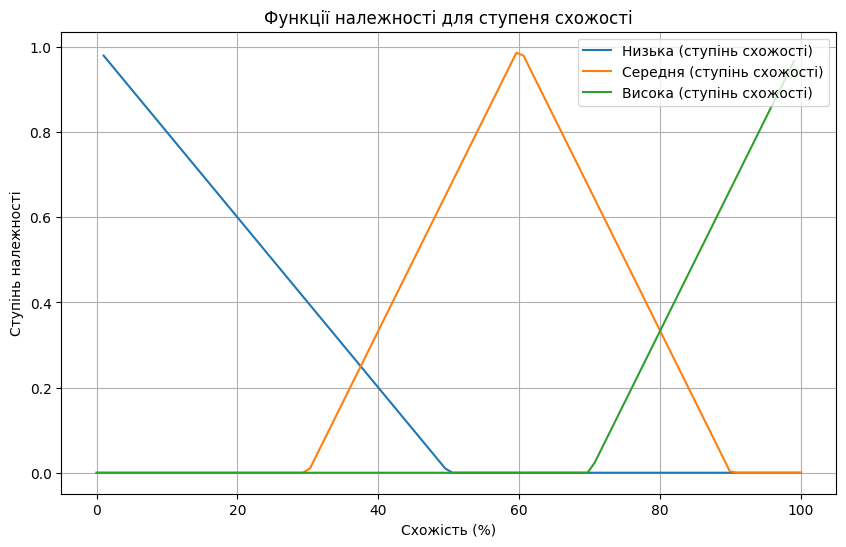

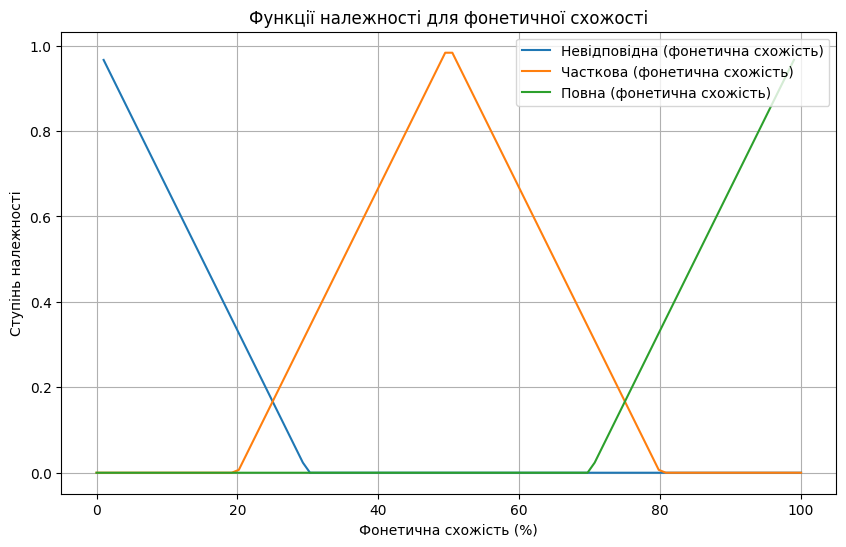

In [87]:
# Функція належності
def trimf(x, params):
    a, b, c = params
    return np.maximum(np.minimum((x - a) / (b - a), (c - x) / (c - b)), 0)

# Нечіткі множини для ступеня схожості
x = np.linspace(0, 100, 100)
low = trimf(x, [0, 0, 50])
medium = trimf(x, [30, 60, 90])
high = trimf(x, [70, 100, 100])

# Нечіткі множини для фонетичної схожості
sx_low = trimf(x, [0, 0, 30])  # Невідповідна
sx_partial = trimf(x, [20, 50, 80])  # Часткова
sx_full = trimf(x, [70, 100, 100])  # Повна

# Візуалізація
plt.figure(figsize=(10, 6))
plt.plot(x, low, label='Низька (ступінь схожості)')
plt.plot(x, medium, label='Середня (ступінь схожості)')
plt.plot(x, high, label='Висока (ступінь схожості)')
plt.title('Функції належності для ступеня схожості')
plt.xlabel('Схожість (%)')
plt.ylabel('Ступінь належності')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x, sx_low, label='Невідповідна (фонетична схожість)')
plt.plot(x, sx_partial, label='Часткова (фонетична схожість)')
plt.plot(x, sx_full, label='Повна (фонетична схожість)')
plt.title('Функції належності для фонетичної схожості')
plt.xlabel('Фонетична схожість (%)')
plt.ylabel('Ступінь належності')
plt.legend()
plt.grid(True)
plt.show()

Створення бази правил

In [88]:
# Правила
rules = [
    "Якщо ступінь схожості висока та фонетична схожість повна, то терміни належать до однієї групи",
    "Якщо ступінь схожості середня та довжина термінів коротка, то ймовірність належності висока",
    "Якщо ступінь схожості низька та фонетична схожість невідповідна, то терміни належать до різних груп"
]
print("\nПравила виведення:")
for rule in rules:
    print(f"- {rule}")


Правила виведення:
- Якщо ступінь схожості висока та фонетична схожість повна, то терміни належать до однієї групи
- Якщо ступінь схожості середня та довжина термінів коротка, то ймовірність належності висока
- Якщо ступінь схожості низька та фонетична схожість невідповідна, то терміни належать до різних груп


Дефазифікація результатів

In [93]:
# Обчислення схожості
def calculate_similarity(jw, sx):
    return round((jw * 0.8 + sx * 0.2), 2)

def create_comparison_table(df, threshold=70):
    results = []
    for i in range(len(df)):
        expedia = df.loc[i, 'Expedia']
        booking = df.loc[i, 'Booking']
        
        jw = fuzz.token_sort_ratio(expedia, booking) / 100
        sx = soundex_similarity(expedia, booking) / 100
        dl = damerau_levenshtein_distance(expedia, booking)
        prob = calculate_similarity(jw, sx)
        
        # Враховуємо довжину термінів у правилах
        expedia_len = df.loc[i, 'expedia_length_class']
        booking_len = df.loc[i, 'booking_length_class']
        
        # Застосовуємо правила
        if prob >= 0.7 and sx == 1.0:  # Висока схожість і повна фонетична схожість
            decision = "Належить"
        elif 0.3 <= prob < 0.7 and (expedia_len == 'короткий' or booking_len == 'короткий'):  # Середня схожість і коротка довжина
            decision = "Ймовірно належить"
        elif prob < 0.5 and sx == 0.0:  # Низька схожість і невідповідна фонетична схожість
            decision = "Не належить"
        else:
            decision = "Невизначено"
        
        results.append([
            df.loc[i, 'ID'],
            expedia, booking,
            round(jw, 2), round(sx, 2),
            dl, f"{int(prob * 100)}%", decision
        ])
    
    # Сортуємо за ймовірністю для топ-10
    results.sort(key=lambda x: int(x[6].replace('%', '')), reverse=True)
    top_10 = results[:10]
    
    headers = ["ID", "Expedia", "Booking", "JW", "Soundex", "D-L Dist", "Ймовірність", "Рішення"]
    table = tabulate(top_10, headers=headers, tablefmt="grid", stralign="center", numalign="center")
    print(f"\nТоп-10 пар за ймовірністю (поріг = {threshold}%):")
    print(table)
    
    # Виведення повної таблиці (усі записи)
    full_table = tabulate(results, headers=headers, tablefmt="grid", stralign="center", numalign="center")
    print(f"\nПовна таблиця порівнянь (усі {len(results)} пар):")
    print(full_table)
    
    return results

# Виклик із налаштуванням порогу
results = create_comparison_table(df, threshold=80)


Топ-10 пар за ймовірністю (поріг = 80%):
+------+-------------------------------------+-------------------------------------------+------+-----------+------------+---------------+-----------+
|  ID  |               Expedia               |                  Booking                  |  JW  |  Soundex  |  D-L Dist  |  Ймовірність  |  Рішення  |
+======+=====================================+===========================================+======+===========+============+===============+===========+
|  48  |            Deluxe Suite             |               Deluxe Suite                |  1   |     1     |     0      |     100%      | Належить  |
+------+-------------------------------------+-------------------------------------------+------+-----------+------------+---------------+-----------+
|  95  |     Regency Club, Mountain View     |        Regency Club Mountain View         | 0.98 |     1     |     1      |      98%      | Належить  |
+------+-------------------------------------+------

In [97]:
# Обчислення схожості
def calculate_similarity(jw, sx):
    return round((jw * 0.8 + sx * 0.2), 2)

def create_comparison_table(df, threshold=70):
    results = []
    for i in range(len(df)):
        expedia = df.loc[i, 'Expedia']
        booking = df.loc[i, 'Booking']
        
        jw = fuzz.token_sort_ratio(expedia, booking) / 100
        sx = soundex_similarity(expedia, booking) / 100
        dl = damerau_levenshtein_distance(expedia, booking)
        prob = calculate_similarity(jw, sx)
        
        # Враховуємо довжину термінів у правилах
        expedia_len = df.loc[i, 'expedia_length_class']
        booking_len = df.loc[i, 'booking_length_class']
        
        # Застосовуємо правила
        if prob >= 0.7 and sx == 1.0:  # Висока схожість і повна фонетична схожість
            decision = "Належить"
        elif 0.3 <= prob < 0.7 and (expedia_len == 'короткий' or booking_len == 'короткий'):  # Середня схожість і коротка довжина
            decision = "Ймовірно належить"
        elif prob < 0.5 and sx == 0.0:  # Низька схожість і невідповідна фонетична схожість
            decision = "Не належить"
        else:
            decision = "Невизначено"
        
        results.append([
            df.loc[i, 'ID'],
            expedia, booking,
            round(jw, 2), round(sx, 2),
            dl, f"{int(prob * 100)}%", decision
        ])
    
    # Сортуємо за ймовірністю для топ-10
    results.sort(key=lambda x: int(x[6].replace('%', '')), reverse=True)
    top_10 = results[:10]
    
    headers = ["ID", "Expedia", "Booking", "JW", "Soundex", "D-L Dist", "Ймовірність", "Рішення"]
    
    # Виведення топ-10 у консоль
    table = tabulate(top_10, headers=headers, tablefmt="grid", stralign="center", numalign="center")
    print(f"\nТоп-10 пар за ймовірністю (поріг = {threshold}%):")
    print(table)
    
    # Збереження повної таблиці у файл
    full_table = tabulate(results, headers=headers, tablefmt="grid", stralign="center", numalign="center")
    with open('full_comparison_table.txt', 'w', encoding='utf-8') as f:
        f.write(f"Повна таблиця порівнянь (усі {len(results)} пар):\n")
        f.write(full_table)
    
    print(f"\nПовна таблиця порівнянь (усі {len(results)} пар) збережена у файл 'full_comparison_table.txt'.")
    
    # Виведення перших 20 рядків повної таблиці у консоль для демонстрації
    print("\nПерші 20 рядків повної таблиці порівнянь:")
    preview_table = tabulate(results[:20], headers=headers, tablefmt="grid", stralign="center", numalign="center")
    print(preview_table)
    
    return results

In [98]:
# Виклик із налаштуванням порогу
results_80 = create_comparison_table(df, threshold=80)


Топ-10 пар за ймовірністю (поріг = 80%):
+------+-------------------------------------+-------------------------------------------+------+-----------+------------+---------------+-----------+
|  ID  |               Expedia               |                  Booking                  |  JW  |  Soundex  |  D-L Dist  |  Ймовірність  |  Рішення  |
+======+=====================================+===========================================+======+===========+============+===============+===========+
|  48  |            Deluxe Suite             |               Deluxe Suite                |  1   |     1     |     0      |     100%      | Належить  |
+------+-------------------------------------+-------------------------------------------+------+-----------+------------+---------------+-----------+
|  95  |     Regency Club, Mountain View     |        Regency Club Mountain View         | 0.98 |     1     |     1      |      98%      | Належить  |
+------+-------------------------------------+------

In [95]:
results_70 = create_comparison_table(df, threshold=70)


Топ-10 пар за ймовірністю (поріг = 70%):
+------+-------------------------------------+-------------------------------------------+------+-----------+------------+---------------+-----------+
|  ID  |               Expedia               |                  Booking                  |  JW  |  Soundex  |  D-L Dist  |  Ймовірність  |  Рішення  |
+======+=====================================+===========================================+======+===========+============+===============+===========+
|  48  |            Deluxe Suite             |               Deluxe Suite                |  1   |     1     |     0      |     100%      | Належить  |
+------+-------------------------------------+-------------------------------------------+------+-----------+------------+---------------+-----------+
|  95  |     Regency Club, Mountain View     |        Regency Club Mountain View         | 0.98 |     1     |     1      |      98%      | Належить  |
+------+-------------------------------------+------

In [94]:
def classic_comparison(df, threshold=80):
    results_classic = []
    for i in range(len(df)):
        expedia = df.loc[i, 'Expedia']
        booking = df.loc[i, 'Booking']
        jw = fuzz.token_sort_ratio(expedia, booking)
        decision = "Належить" if jw >= threshold else "Не належить"
        results_classic.append([df.loc[i, 'ID'], jw, decision])
    results_classic.sort(key=lambda x: x[1], reverse=True)
    top_10_classic = results_classic[:10]
    print("\nТоп-10 за класичним методом (лише Jaro-Winkler):")
    print(tabulate(top_10_classic, headers=["ID", "JW", "Рішення"], tablefmt="grid"))
    
    # Повна таблиця для класичного методу
    full_table_classic = tabulate(results_classic, headers=["ID", "JW", "Рішення"], tablefmt="grid")
    print(f"\nПовна таблиця для класичного методу (усі {len(results_classic)} пар):")
    print(full_table_classic)

classic_comparison(df, threshold=80)


Топ-10 за класичним методом (лише Jaro-Winkler):
+------+----------+-----------+
|   ID |       JW | Рішення   |
+======+==========+===========+
|   48 | 100      | Належить  |
+------+----------+-----------+
|   95 |  98.1132 | Належить  |
+------+----------+-----------+
|   96 |  97.8723 | Належить  |
+------+----------+-----------+
|   77 |  95.8333 | Належить  |
+------+----------+-----------+
|    5 |  88.8889 | Належить  |
+------+----------+-----------+
|   74 |  88.8889 | Належить  |
+------+----------+-----------+
|   27 |  86.7925 | Належить  |
+------+----------+-----------+
|   26 |  85.7143 | Належить  |
+------+----------+-----------+
|   58 |  85.7143 | Належить  |
+------+----------+-----------+
|   86 |  85.4167 | Належить  |
+------+----------+-----------+

Повна таблиця для класичного методу (усі 103 пар):
+------+----------+-------------+
|   ID |       JW | Рішення     |
+======+==========+=============+
|   48 | 100      | Належить    |
+------+----------+-------